In [ ]:
"""
Principal Component Analysis (PCA) 
This notebook applies PCA to the scaled core clustering variables to:
1. Understand the underlying dimensional structure of the data
2. Assess whether dimensionality reduction is appropriate
3. Visualize data structure in lower dimensions
4. Determine variance explained by each component
5. Evaluate whether all three variables contribute unique information

PCA is NOT used for dimensionality reduction here (all 3 variables are kept), but rather as an exploratory tool 
to understand data structure before clustering.

Author: Hajar Cherrouk
"""

import sys
sys.path.append('../../')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler #this is a crtical preprocessing step for PCA
import pickle


sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(14, 8)
plt.rcParams['font.size']=10 

df = pd.read_csv("../../data/processed/nhanes_metabolic_scaled.csv")

# core variables (scaled versions)
core_vars_scaled = ['LBXGLU_scaled', 'LBXTLG_scaled', 'BMXWAIST_scaled']
core_vars_original = ['LBXGLU', 'LBXTLG', 'BMXWAIST']


print("Prinipal Component Analysis (PCA)")
print(f"\nDataset: {df.shape[0]:,} participants")
print(f"Variables for PCA: {core_vars_scaled}")
print(f"\nSetup complete")

Prinipal Component Analysis (PCA)

Dataset: 3,047 participants
Variables for PCA: ['LBXGLU_scaled', 'LBXTLG_scaled', 'BMXWAIST_scaled']

Setup complete


In [ ]:
'''This section transitions from preperation to execution and also
provides a detailed quantitative and qualitative interpretaion of 
the results.  This is where the theoretical promises of the PCA 
are realised and measured'''

#  extract scaled variables and pca initialization
 #selets only the 3 specified cols resulting in new, smaller df
X_scaled = df[core_vars_scaled].values  #converts the df into array wich is crucial step

# apply PCA with all components
#this guarentees that no dimensionality reduction will occur
pca = PCA(n_components=3) 
X_pca = pca.fit_transform(X_scaled) #executes the 2 core steps of API

# create df with PC scores (integrating results back into the df)
#this converts the array back into a df for easier manipulation and analysis
pca_df = pd.DataFrame(X_pca,columns=['PC1', 'PC2', 'PC3'])

# add to main dataframe (appends the new computed prinipal component scores as new cola to main df)
df['PC1'] = pca_df['PC1']
df['PC2'] = pca_df['PC2']
df['PC3'] = pca_df['PC3']

print("PCA results: Variance explained ")

#variance explained by each component
#this section extracts and prepares the key metrics for interpreting the PCA
#array containing the proprtion of total dataset variance
variance_explained = pca.explained_variance_ratio_  #eigenvalues normalized by the sum of all eigenval
cumulative_variance = np.cumsum(variance_explained)

print(f"\nVariance Explained by Each Principal Component:")
print(f"{'Component':<15} {'Variance Explained':<20} {'Cumulative Variance':<20}")

for i, (var_exp, cum_var) in enumerate(zip(variance_explained, cumulative_variance)):
    print(f"PC{i+1:<14} {var_exp*100:>18.2f}% {cum_var*100:>19.2f}%")

print(f"\n Interpretation:")
if variance_explained[0] > 0.70:
    print(f"   - PC1 explains >{variance_explained[0]*100:.0f}% -> High redundancy, consider dimensionality reduction")
elif variance_explained[0] > 0.50:
    print(f"  - PC1 explains {variance_explained[0]*100:.1f}% -> Moderate correlation between variables")
else:
    print(f"   - PC1 explains {variance_explained[0]*100:.1f}% -> Low redundancy, all variables contribute unique info")

if cumulative_variance[1] < 0.85:
    print(f"   - PC1+PC2 explain {cumulative_variance[1]*100:.1f}% -> Need all 3 PCs to capture 85%+ variance")
    print(f"   -  All 3 original variables should be retained for clustering")
else:
    print(f"   - PC1+PC2 explain {cumulative_variance[1]*100:.1f}% -> Could potentially use 2 PCs")

print("\n PCA transformation complete")

PCA results: Variance explained 

Variance Explained by Each Principal Component:
Component       Variance Explained   Cumulative Variance 
PC1                           70.37%               70.37%
PC2                           21.72%               92.09%
PC3                            7.91%              100.00%

 Interpretation:
   - PC1 explains >70% -> High redundancy, consider dimensionality reduction
   - PC1+PC2 explain 92.1% -> Could potentially use 2 PCs

 PCA transformation complete


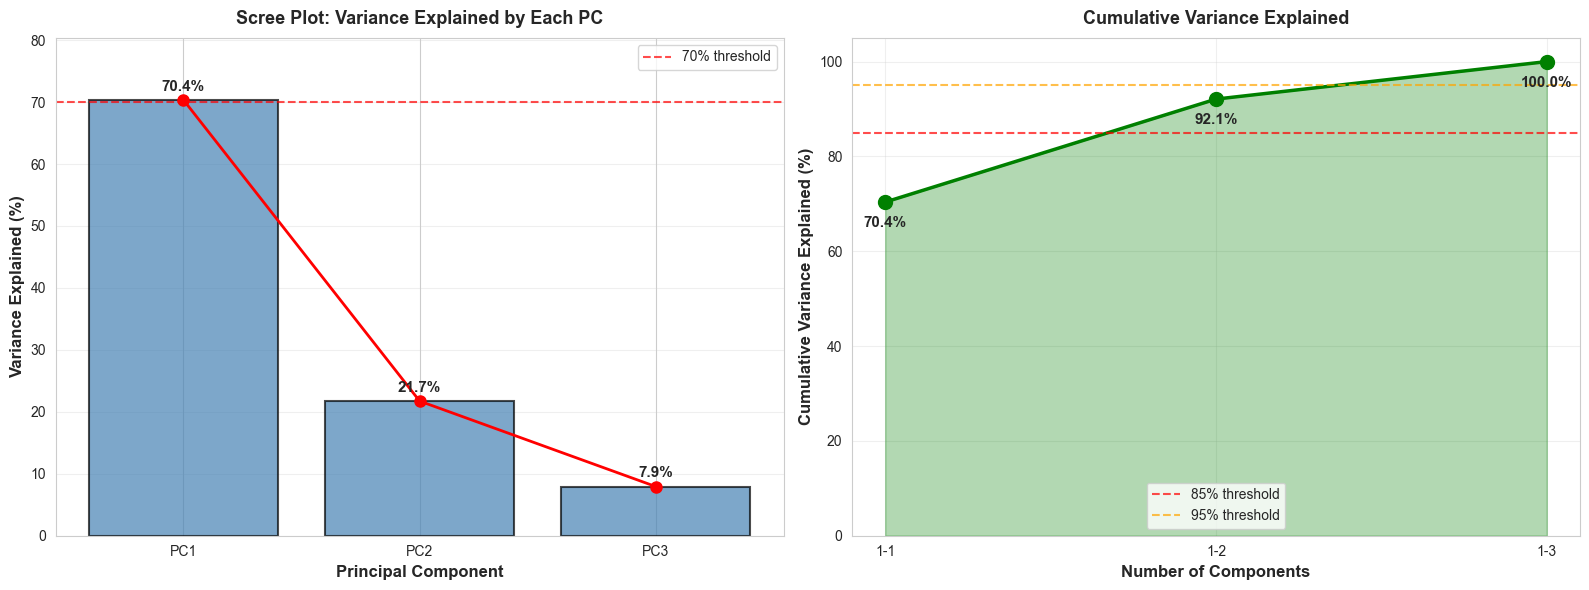


Figure saved to: results/figures/pca_scree_plot.png


In [ ]:
# create scree plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Variance explained by each component
ax = axes[0]
components = np.arange(1, len(variance_explained) + 1)
ax.bar(components, variance_explained * 100, alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.5)
ax.plot(components, variance_explained * 100, 'ro-', linewidth=2, markersize=8)

# add value labels on bars
for i, v in enumerate(variance_explained * 100):
    ax.text(i + 1, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# add reference line at 70% (common threshold)
ax.axhline(y=70, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='70% threshold')

ax.set_xlabel('Principal Component', fontsize=12, fontweight='bold')
ax.set_ylabel('Variance Explained (%)', fontsize=12, fontweight='bold')
ax.set_title('Scree Plot: Variance Explained by Each PC', fontsize=13, fontweight='bold', pad=10)
ax.set_xticks(components)
ax.set_xticklabels([f'PC{i}' for i in components])
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(variance_explained * 100) + 10)

# Plot 2: Cumulative variance explained (desiion tool)
#create a line plot with area fill for the cumulative variance
ax = axes[1]
ax.plot(components, cumulative_variance * 100, 'go-', linewidth=2.5, markersize=10)
#visually emphasises the 'area of captured variance' and creates and intuitive 'filling up' metaphor
ax.fill_between(components, cumulative_variance * 100, alpha=0.3, color='green')

for i, v in enumerate(cumulative_variance * 100):
    ax.text(i + 1, v - 3, f'{v:.1f}%', ha='center', va='top', fontweight='bold', fontsize=11)

#introduces 2 desicion thresholds 
ax.axhline(y=85, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='85% threshold')
ax.axhline(y=95, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='95% threshold')

ax.set_xlabel('Number of Components', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Variance Explained (%)', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Variance Explained', fontsize=13, fontweight='bold', pad=10)
ax.set_xticks(components)
ax.set_xticklabels([f'1-{i}' for i in components])
ax.legend()
ax.grid(alpha=0.3)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.savefig('../../results/figures/pca_scree_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure saved to: results/figures/pca_scree_plot.png")

Principal Component loadings

Loadings represent how much each original variable contributes to each PC
(Higher absolute value = stronger contribution)

                       PC1    PC2    PC3
Glucose              2.051 -0.347 -0.047
Triglycerides        0.601  1.134 -0.098
Waist Circumference  0.218  0.134  0.712
Variable cotributions to eah PC (% of squared loading)
--------------------------------------------------------------------------------

PC1:
  Glucose                  :   91.1%
  Triglycerides            :    7.8%
  Waist Circumference      :    1.0%

PC2:
  Glucose                  :    8.4%
  Triglycerides            :   90.3%
  Waist Circumference      :    1.3%

PC3:
  Glucose                  :    0.4%
  Triglycerides            :    1.9%
  Waist Circumference      :   97.7%


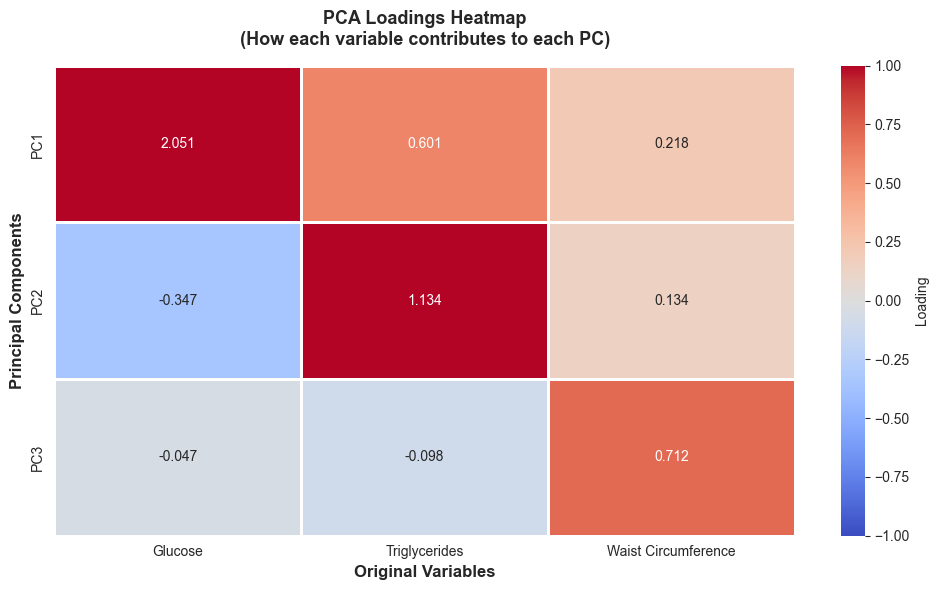


igure saved to: results/figures/pca_loadings_heatmap.png


In [ ]:
# The loading providdes the bridge between the abstract mathematical components and the original values

# calculating component loadings (coefficients)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create DataFrame for better visualization
loadings_df = pd.DataFrame(
    loadings,
    columns=['PC1', 'PC2', 'PC3'],
    index=['Glucose', 'Triglycerides', 'Waist Circumference']
)

print("Principal Component loadings")
print("\nLoadings represent how much each original variable contributes to each PC")
print("(Higher absolute value = stronger contribution)")
print("\n" + loadings_df.round(3).to_string())

# Calculate contribution percentages
print("Variable cotributions to eah PC (% of squared loading)")


for pc in ['PC1', 'PC2', 'PC3']:
    #convert the correlations into variance explanations
    squared_loadings = loadings_df[pc] ** 2
    contribution_pct = (squared_loadings / squared_loadings.sum()) * 100
    print(f"\n{pc}:")
    for var, contrib in contribution_pct.items():
        print(f"  {var:25s}: {contrib:>6.1f}%")
#visualise loadings as heatmaps
fig, ax = plt.subplots(figsize=(10, 6))

#here i transposed the df sice it is more intuitive to read
sns.heatmap(loadings_df.T, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            linewidths=1, cbar_kws={'label': 'Loading'}, 
            vmin=-1, vmax=1, ax=ax)

ax.set_xlabel('Original Variables', fontsize=12, fontweight='bold')
ax.set_ylabel('Principal Components', fontsize=12, fontweight='bold')
ax.set_title('PCA Loadings Heatmap\n(How each variable contributes to each PC)', 
             fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('../../results/figures/pca_loadings_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nigure saved to: results/figures/pca_loadings_heatmap.png")

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


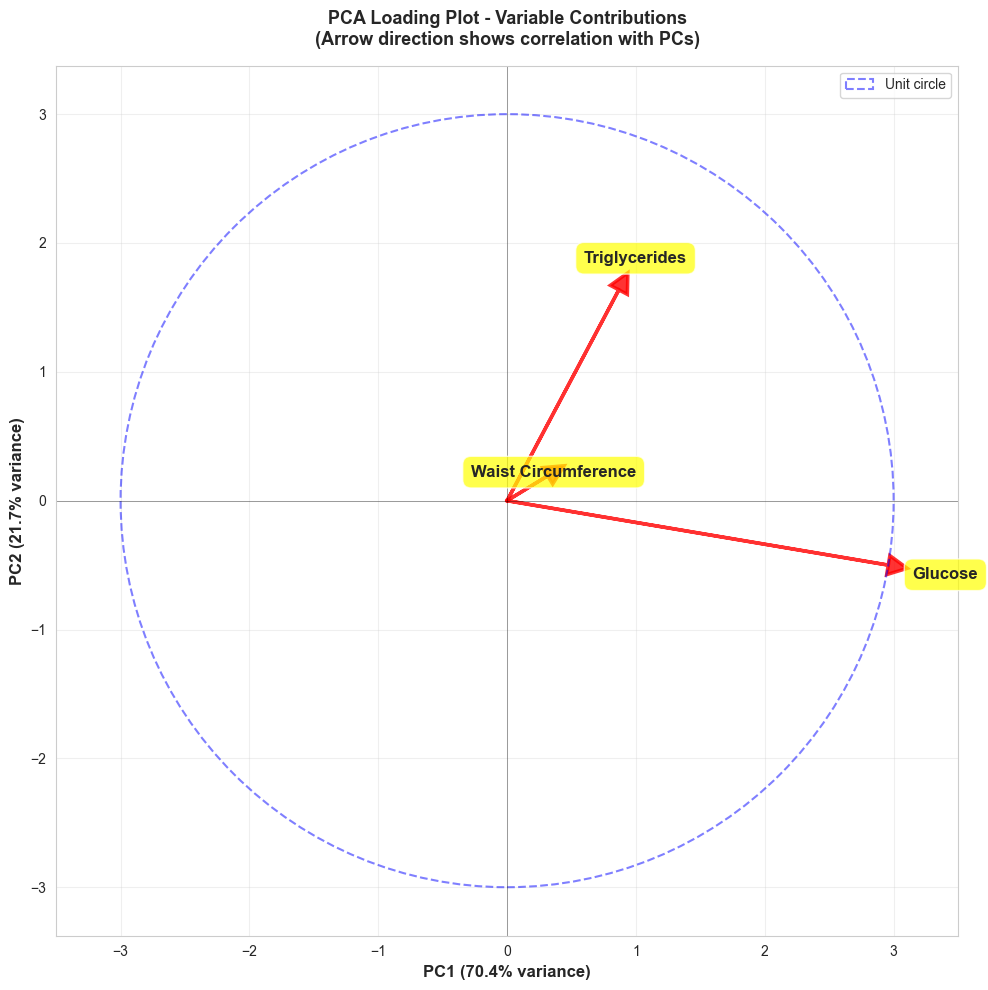


 Figure saved to: results/figures/pca_loading_plot.png


In [ ]:
'''for more details on how to read this plot,
 please visit docs/methodological_decisions.md'''

#The geometric interpretation
fig, ax = plt.subplots(figsize=(10, 10))

arrow_scale = 3

#we will be ignoring PC3  for this visualisation
max_length = (loadings_df[['PC1','PC2']]**2).sum(axis=1).pow(0.5).max() #pythagorean theorem in action
scale_factor = arrow_scale / max_length

for i, var in enumerate(['Glucose', 'Triglycerides', 'Waist Circumference']):
    ax.arrow(0, 0, 
             loadings_df.loc[var, 'PC1'] * scale_factor, 
             loadings_df.loc[var, 'PC2'] * scale_factor,
             head_width=0.15, head_length=0.15, fc='red', ec='red', 
             linewidth=2.5, alpha=0.8)
    
    label_x = loadings_df.loc[var, 'PC1'] * scale_factor * 1.15
    label_y = loadings_df.loc[var, 'PC2'] * scale_factor * 1.15
    ax.text(label_x, label_y, var, fontsize=12, fontweight='bold',
            ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

circle = plt.Circle((0, 0), arrow_scale, color='blue', fill=False, linestyle='--', linewidth=1.5, alpha=0.5, label='Unit circle')
ax.add_patch(circle)

ax.axhline(y=0, color='k', linewidth=0.5, alpha=0.5)
ax.axvline(x=0, color='k', linewidth=0.5, alpha=0.5)
ax.set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}% variance)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}% variance)', fontsize=12, fontweight='bold')
ax.set_title('PCA Loading Plot - Variable Contributions\n(Arrow direction shows correlation with PCs)', fontsize=13, fontweight='bold', pad=15)
ax.grid(alpha=0.3)
ax.axis('equal')
padding = 0.5
ax.set_xlim(-(arrow_scale + padding), arrow_scale + padding)
ax.set_ylim(-(arrow_scale + padding), arrow_scale + padding)
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('../../results/figures/pca_loading_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Figure saved to: results/figures/pca_loading_plot.png")


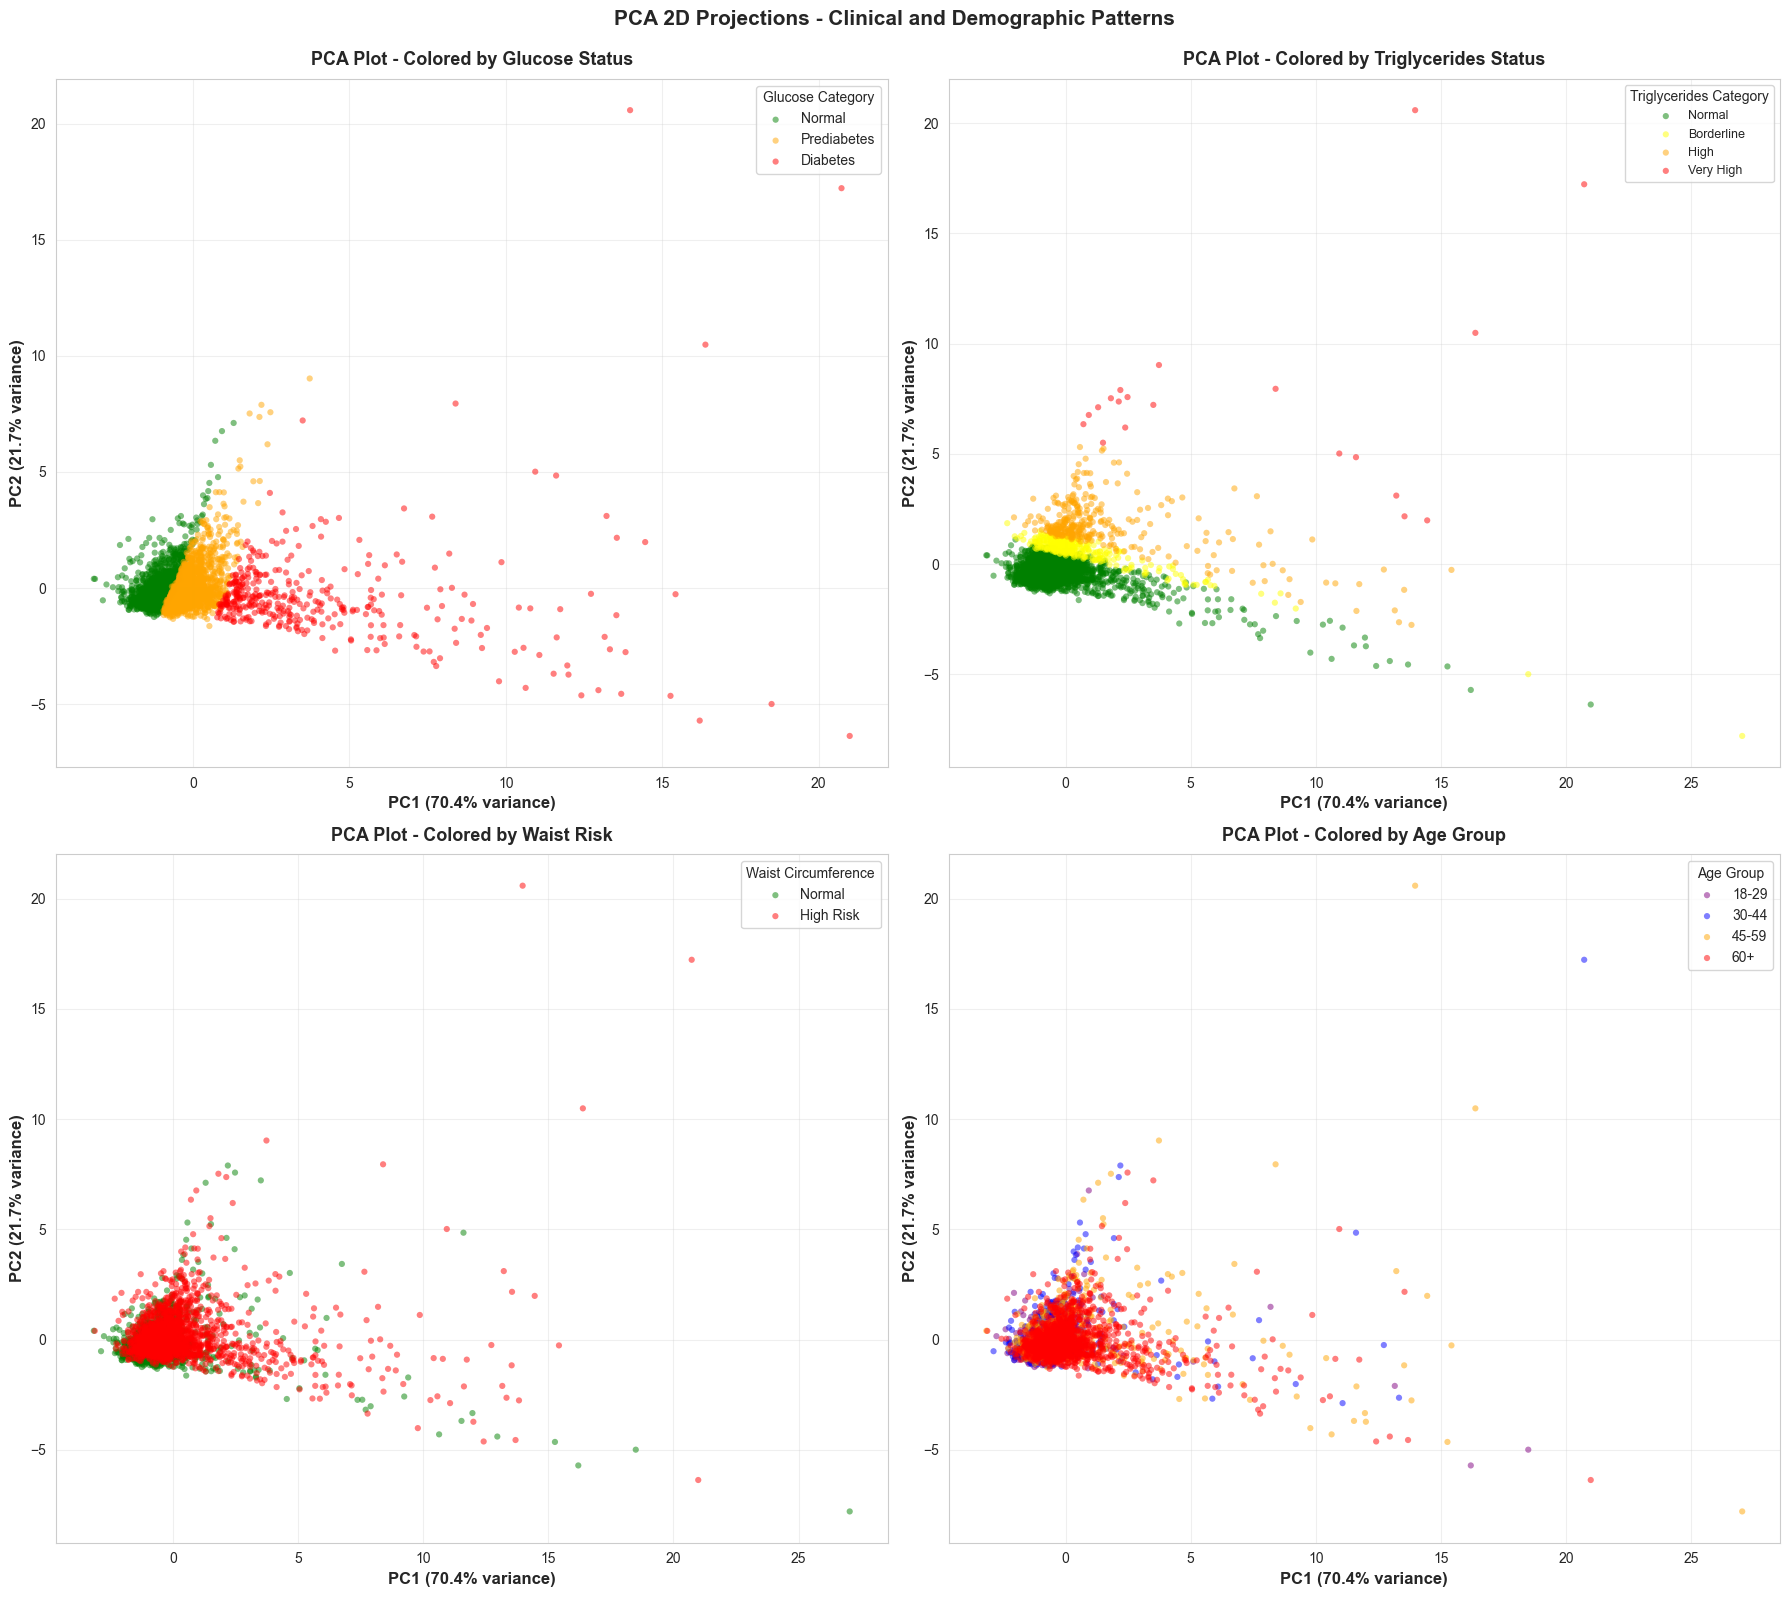


 Figure saved to: results/figures/pca_2d_clinical_categories.png


In [ ]:
'''The validation phase: The purpose of this is to visually verify that the mathematical patterns discovered by PCA aligh
biologically and clinically known groupings, thereby valifdation both the PCA transformation and the 
clinical relevance of the resulting components'''
# create 2D scatter plot of PC1 vs PC2, colored by clinical categories
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Plot 1: Color by Glucose Category
ax = axes[0, 0]

#uses intuitive 'traffic light' color scheme
for category, color in [('Normal', 'green'), ('Prediabetes', 'orange'), ('Diabetes', 'red')]:
    #this mask will be used to filter the df to show only points belonging to 1 clinical categroy at a time
    mask = df['glucose_category'] == category
    ax.scatter(df.loc[mask, 'PC1'], df.loc[mask, 'PC2'], 
               c=color, label=category, alpha=0.5, s=20, edgecolors='none')

ax.set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}% variance)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}% variance)', fontsize=12, fontweight='bold')
ax.set_title('PCA Plot - Colored by Glucose Status', fontsize=13, fontweight='bold', pad=10)
ax.legend(title='Glucose Category', loc='best')
ax.grid(alpha=0.3)

# Plot 2: Color by Triglycerides Category
ax = axes[0, 1]
trig_colors = {'Normal': 'green', 'Borderline': 'yellow', 'High': 'orange', 'Very High': 'red'}
for category, color in trig_colors.items():
    mask = df['triglycerides_category'] == category

    #prevent trying to plot categories that have no data points
    if mask.sum() > 0:
        ax.scatter(df.loc[mask, 'PC1'], df.loc[mask, 'PC2'], 
                   c=color, label=category, alpha=0.5, s=20, edgecolors='none')

ax.set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}% variance)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}% variance)', fontsize=12, fontweight='bold')
ax.set_title('PCA Plot - Colored by Triglycerides Status', fontsize=13, fontweight='bold', pad=10)
ax.legend(title='Triglycerides Category', loc='best', fontsize=9)
ax.grid(alpha=0.3)

# Plot 3: Color by Waist Risk
ax = axes[1, 0]
for category, color in [('Normal', 'green'), ('High Risk', 'red')]:
    mask = df['waist_risk'] == category
    ax.scatter(df.loc[mask, 'PC1'], df.loc[mask, 'PC2'], 
               c=color, label=category, alpha=0.5, s=20, edgecolors='none')

ax.set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}% variance)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}% variance)', fontsize=12, fontweight='bold')
ax.set_title('PCA Plot - Colored by Waist Risk', fontsize=13, fontweight='bold', pad=10)
ax.legend(title='Waist Circumference', loc='best')
ax.grid(alpha=0.3)

# Plot 4: Color by Age Group
ax = axes[1, 1]
age_colors = {'18-29': 'purple', '30-44': 'blue', '45-59': 'orange', '60+': 'red'}
for category, color in age_colors.items():
    mask = df['age_group'] == category
    ax.scatter(df.loc[mask, 'PC1'], df.loc[mask, 'PC2'], 
               c=color, label=category, alpha=0.5, s=20, edgecolors='none')

ax.set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}% variance)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}% variance)', fontsize=12, fontweight='bold')
ax.set_title('PCA Plot - Colored by Age Group', fontsize=13, fontweight='bold', pad=10)
ax.legend(title='Age Group', loc='best')
ax.grid(alpha=0.3)

plt.suptitle('PCA 2D Projections - Clinical and Demographic Patterns', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../../results/figures/pca_2d_clinical_categories.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Figure saved to: results/figures/pca_2d_clinical_categories.png")

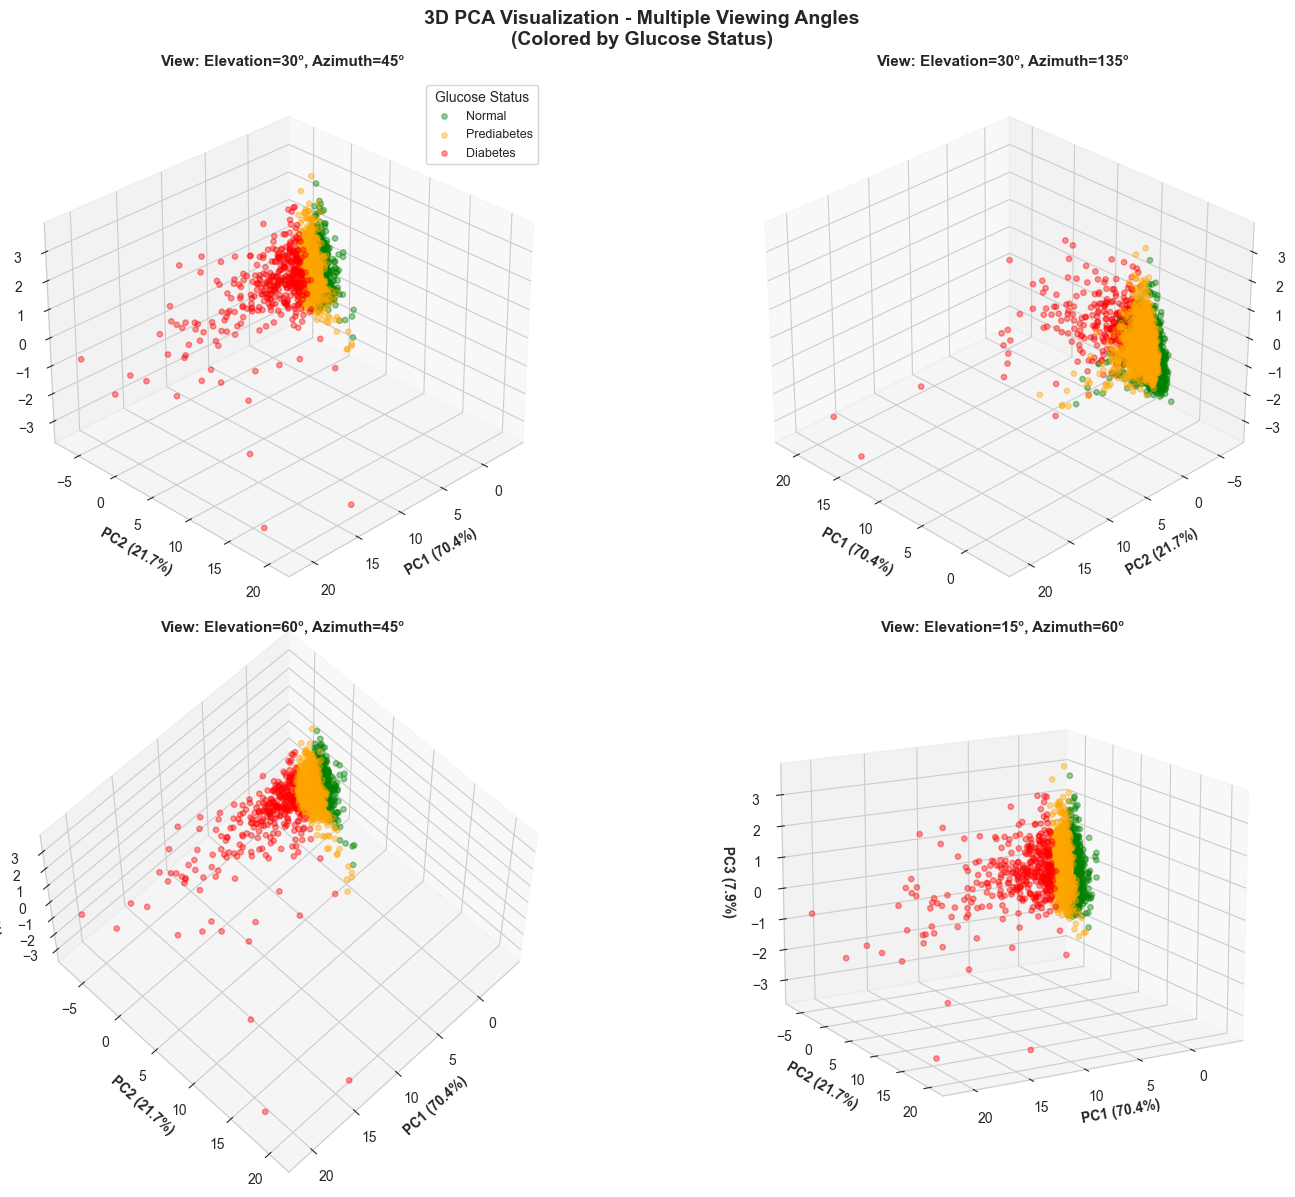


 Figure saved to: results/figures/pca_3d_visualization.png


In [ ]:
''' The purpose of this is just to show PCA transformed data from a different viewing
(i did it because a single viewpoint can hide important spatial relationships and cluster structres)'''

#While this module may later appear unused, simply importing it registers the '3d' projection plot with matplotlib
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))

# create 4 subplots with different rotation angles
angles = [(30, 45), (30, 135), (60, 45), (15, 60)]

for idx, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(2, 2, idx+1, projection='3d')
    
    # color by glucose category
    for category, color in [('Normal', 'green'), ('Prediabetes', 'orange'), ('Diabetes', 'red')]:
        mask = df['glucose_category'] == category
        ax.scatter(df.loc[mask, 'PC1'], 
                   df.loc[mask, 'PC2'], 
                   df.loc[mask, 'PC3'],
                   c=color, label=category, alpha=0.4, s=15)
    
    ax.set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}%)', fontsize=10, fontweight='bold')
    ax.set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}%)', fontsize=10, fontweight='bold')
    ax.set_zlabel(f'PC3 ({variance_explained[2]*100:.1f}%)', fontsize=10, fontweight='bold')
    ax.set_title(f'View: Elevation={elev}°, Azimuth={azim}°', fontsize=11, fontweight='bold', pad=10)
    ax.view_init(elev=elev, azim=azim)
    
    if idx == 0:
        ax.legend(title='Glucose Status', loc='upper right', fontsize=9)

plt.suptitle('3D PCA Visualization - Multiple Viewing Angles\n(Colored by Glucose Status)', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('../../results/figures/pca_3d_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Figure saved to: results/figures/pca_3d_visualization.png")

<>:2: SyntaxWarning: invalid escape sequence '\q'
<>:2: SyntaxWarning: invalid escape sequence '\q'
C:\Users\cherr\AppData\Local\Temp\ipykernel_14200\3489123211.py:2: SyntaxWarning: invalid escape sequence '\q'
  print("\question: Do natural clusters appear in the PCA space?")


data structure assessment
\question: Do natural clusters appear in the PCA space?


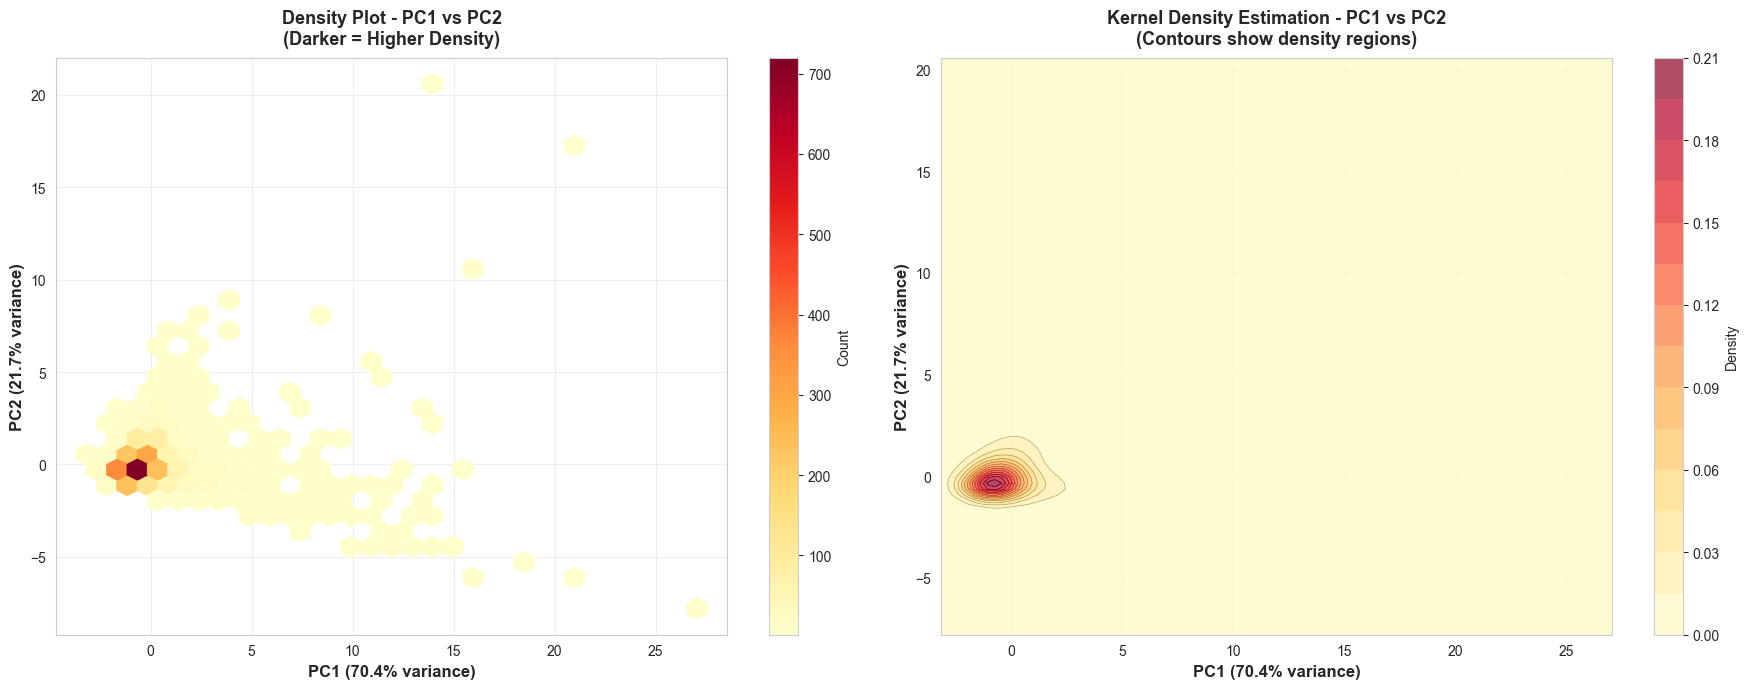


 Figure saved to: results/figures/pca_density_analysis.png


In [ ]:
'''The cluster detection phase: It uses 2 complementary density estimation
techniques to reveal the underlying distribution structure that might not be apparent 
from raw scatter plots alone'''

print("data structure assessment")
print("\question: Do natural clusters appear in the PCA space?")

# Calculate density in PC1-PC2 space using kernel density estimation
from scipy.stats import gaussian_kde

# sample for computational efficiency

#this ensures that we dont use more points than actually exist
sample_size = min(1000, len(df))
sample_idx = np.random.choice(len(df), sample_size, replace=False)
pc1_sample = df.loc[sample_idx, 'PC1'].values
pc2_sample = df.loc[sample_idx, 'PC2'].values

#cCreate density plot
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# plot 1: Hexbin (density)
ax = axes[0]
#uses the full dataset for maximum accuracy, since hexbin is computationally efficient 
#yellow:low density, red: high density 
#hexagons with just one point will be colored (not transparent)
hexbin = ax.hexbin(df['PC1'], df['PC2'], gridsize=30, cmap='YlOrRd', mincnt=1)
ax.set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}% variance)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}% variance)', fontsize=12, fontweight='bold')
ax.set_title('Density Plot - PC1 vs PC2\n(Darker = Higher Density)', 
             fontsize=13, fontweight='bold', pad=10)
plt.colorbar(hexbin, ax=ax, label='Count')
ax.grid(alpha=0.3)

# plot 2: Contour plot (KDE)
ax = axes[1]

#kde computation can fail withh large datasets or num issues so i begin an exception handling block
try:
    # calc kernel density
    xy = np.vstack([pc1_sample, pc2_sample])
    kde = gaussian_kde(xy)
    
    # create grid
    x_min, x_max = df['PC1'].min(), df['PC1'].max()
    y_min, y_max = df['PC2'].min(), df['PC2'].max()
    xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    density = np.reshape(kde(positions).T, xx.shape)
    #contours
    contour = ax.contourf(xx, yy, density, levels=15, cmap='YlOrRd', alpha=0.7)
    ax.contour(xx, yy, density, levels=15, colors='black', linewidths=0.5, alpha=0.3)
    
    ax.set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}% variance)', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}% variance)', fontsize=12, fontweight='bold')
    ax.set_title('Kernel Density Estimation - PC1 vs PC2\n(Contours show density regions)', 
                 fontsize=13, fontweight='bold', pad=10)
    plt.colorbar(contour, ax=ax, label='Density')
    ax.grid(alpha=0.3)
    
except:
    ax.text(0.5, 0.5, 'KDE computation failed\n(dataset may be too large)', 
            transform=ax.transAxes, ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.savefig('../../results/figures/pca_density_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Figure saved to: results/figures/pca_density_analysis.png")


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pickle

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(14, 8)
plt.rcParams['font.size']=10 

# Load data
df = pd.read_csv("../../data/processed/nhanes_metabolic_scaled.csv")
core_vars_scaled = ['LBXGLU_scaled', 'LBXTLG_scaled', 'BMXWAIST_scaled']

# PCA computation
X_scaled = df[core_vars_scaled].values
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Add PC scores to dataframe
df[['PC1', 'PC2', 'PC3']] = X_pca

# Variance explained
variance_explained = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

# PCA loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(
    loadings,
    columns=['PC1', 'PC2', 'PC3'],
    index=['Glucose', 'Triglycerides', 'Waist Circumference']
)

# Print summary
print("PCA Analysis: summary and recommendations\n")

print("Key Findings:")
print(f"   1. PC1 explains {variance_explained[0]*100:.1f}% of variance")
print(f"   2. PC2 explains {variance_explained[1]*100:.1f}% of variance")
print(f"   3. PC3 explains {variance_explained[2]*100:.1f}% of variance")
print(f"   4. First 2 PCs capture {cumulative_variance[1]*100:.1f}% of total variance")
print(f"   5. All 3 PCs needed to capture {cumulative_variance[2]*100:.1f}% of variance\n")

print("Variable Contributions:")
print(f"   Primary contributors to PC1: {loadings_df['PC1'].abs().idxmax()}")
print(f"   Primary contributors to PC2: {loadings_df['PC2'].abs().idxmax()}")
print(f"   Primary contributors to PC3: {loadings_df['PC3'].abs().idxmax()}\n")

print("Dimensionality Assessment:")
if variance_explained[0] < 0.50:
    print("   • PC1 explains <50% → All variables contribute unique information")
    print("   • Low redundancy between glucose, triglycerides, and waist")
    print("   • REC: Keep all 3 original variables for clustering")
elif variance_explained[0] < 0.70:
    print(f"   • PC1 explains {variance_explained[0]*100:.1f}% → Moderate shared variance")
    print("   • Variables are somewhat related but not redundant")
    print("   • REC: Keep all 3 original variables for interpretability")
else:
    print(f"   • PC1 explains {variance_explained[0]*100:.1f}% → High shared variance")
    print("   • Consider using PC1/PC2 for clustering")

if cumulative_variance[1] < 0.85:
    print("\n   • PC1+PC2 capture <85% of variance")
    print(f"   • PC3 contains {variance_explained[2]*100:.1f}% unique information")
    print("   • IMPORTANT: Using only PC1/PC2 would lose information\n")

print("Final decision for clustering:")
print("   → Use ORIGINAL 3 scaled variables (not PCA components)\n")
print("Why:")
print("   1. Only 3 variables (already low dimensional)")
print("   2. Low correlations (r < 0.35) = minimal redundancy")
print("   3. Each variable has clear clinical interpretation")
print("   4. PCA would reduce interpretability without meaningful dimensionality reduction")
print("   5. Clustering algorithms can handle 3D space efficiently\n")

print("Use of PCA:")
print("   • PCA will be used for visualisation (2D plots)")
print("   • PCA will not be used for dimensionality reduction")
print("   • Clustering will be performed on original scaled variables\n")

# Save results
pca_results = {
    'variance_explained': variance_explained,
    'cumulative_variance': cumulative_variance,
    'loadings': loadings_df,
    'pca_object': pca
}
with open('../../data/processed/pca_results.pkl', 'wb') as f:
    pickle.dump(pca_results, f)

df[['SEQN', 'PC1', 'PC2', 'PC3']].to_csv('../../data/processed/pca_scores.csv', index=False)

# PCA summary table
pca_summary = pd.DataFrame({
    'Component': ['PC1', 'PC2', 'PC3'],
    'Variance_Explained_%': variance_explained * 100,
    'Cumulative_Variance_%': cumulative_variance * 100,
    'Primary_Contributor': [
        loadings_df['PC1'].abs().idxmax(),
        loadings_df['PC2'].abs().idxmax(),
        loadings_df['PC3'].abs().idxmax()
    ]
})
pca_summary.to_csv('../../results/tables/pca_summary.csv', index=False)

print("PCA results, PC scores, and summary table saved successfully.")


PCA Analysis: summary and recommendations

Key Findings:
   1. PC1 explains 70.4% of variance
   2. PC2 explains 21.7% of variance
   3. PC3 explains 7.9% of variance
   4. First 2 PCs capture 92.1% of total variance
   5. All 3 PCs needed to capture 100.0% of variance

Variable Contributions:
   Primary contributors to PC1: Glucose
   Primary contributors to PC2: Triglycerides
   Primary contributors to PC3: Waist Circumference

Dimensionality Assessment:
   • PC1 explains 70.4% → High shared variance
   • Consider using PC1/PC2 for clustering
Final decision for clustering:
   → Use ORIGINAL 3 scaled variables (not PCA components)

Why:
   1. Only 3 variables (already low dimensional)
   2. Low correlations (r < 0.35) = minimal redundancy
   3. Each variable has clear clinical interpretation
   4. PCA would reduce interpretability without meaningful dimensionality reduction
   5. Clustering algorithms can handle 3D space efficiently

Use of PCA:
   • PCA will be used for visualisation